In [1]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# for galioma

Epoch [1/100] | Batch [1/1] | Gen Loss: 0.0733
Epoch [2/100] | Batch [1/1] | Gen Loss: 0.0667
Epoch [3/100] | Batch [1/1] | Gen Loss: 0.0625
Epoch [4/100] | Batch [1/1] | Gen Loss: 0.0605
Epoch [5/100] | Batch [1/1] | Gen Loss: 0.0571
Epoch [6/100] | Batch [1/1] | Gen Loss: 0.0533
Epoch [7/100] | Batch [1/1] | Gen Loss: 0.0506
Epoch [8/100] | Batch [1/1] | Gen Loss: 0.0462
Epoch [9/100] | Batch [1/1] | Gen Loss: 0.0438
Epoch [10/100] | Batch [1/1] | Gen Loss: 0.0373
Epoch [11/100] | Batch [1/1] | Gen Loss: 0.0362
Epoch [12/100] | Batch [1/1] | Gen Loss: 0.0348
Epoch [13/100] | Batch [1/1] | Gen Loss: 0.0290
Epoch [14/100] | Batch [1/1] | Gen Loss: 0.0258
Epoch [15/100] | Batch [1/1] | Gen Loss: 0.0269
Epoch [16/100] | Batch [1/1] | Gen Loss: 0.0248
Epoch [17/100] | Batch [1/1] | Gen Loss: 0.0268
Epoch [18/100] | Batch [1/1] | Gen Loss: 0.0250
Epoch [19/100] | Batch [1/1] | Gen Loss: 0.0243
Epoch [20/100] | Batch [1/1] | Gen Loss: 0.0196
Epoch [21/100] | Batch [1/1] | Gen Loss: 0.0193
E

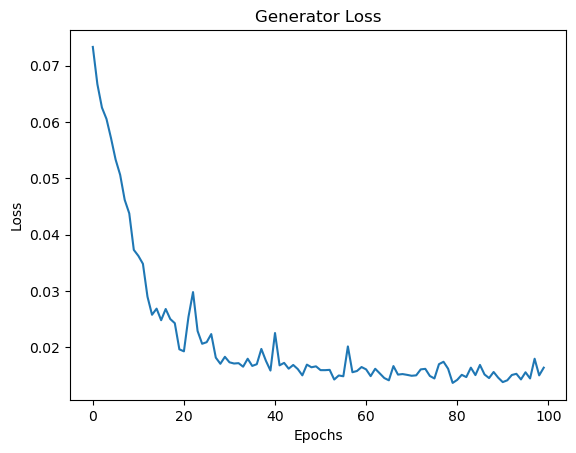

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# Generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)  # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

# Custom Dataset and transformation
class BrainTumorDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_list = os.listdir(data_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_list[idx])
        image = Image.open(image_path).convert("L")  # Convert to grayscale image
        if self.transform:
            image = self.transform(image)
        return image

# Specify the class name for which you want to generate images
class_name = "Glioma"  # Replace this with the desired class name ("glioma", "meningioma", "notumor", "pituitary")

# Custom Dataset and transformation
data_folder = r'C:\Users\ADMIN\project soft computing\IPDataForGlioma'
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.Grayscale(),  # Convert to grayscale image
    transforms.ToTensor(),
])
brain_tumor_dataset = BrainTumorDataset(data_folder, transform=transform)

# DataLoader
batch_size = 8  # Reduce the batch size for large images
train_loader = DataLoader(brain_tumor_dataset, batch_size=batch_size, shuffle=True)


# Instantiate the generator with updated input and output size
z_size = 100  # Noise vector size
g_hidden_size = 32
output_size = 1 * 512 * 512  # Update output size for grayscale images
G = Generator(z_size, g_hidden_size, output_size)

# Optimizer
lr = 0.002
g_optimizer = optim.Adam(G.parameters(), lr)

# Training hyperparameters
num_epochs = 100  # Set the number of training epochs
sample_size = 16
fixed_z = torch.randn(sample_size, z_size)


# Training loop
G.train()
losses = []
criterion = nn.MSELoss()  # Use Mean Squared Error (MSE) loss

output_dir = f"generated_images_{class_name}"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for batch_i, real_images in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_size)
        fake_images = G(z)

        # Reshape and resize fake_images to have the same shape as real_images
        fake_images = fake_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]
        real_images = real_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]

        # Calculate generator loss
        g_loss = criterion(fake_images, real_images)

        # Perform backpropagation and optimization step
        g_loss.backward()
        g_optimizer.step()

        # Print the generator loss
        if batch_i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] | Batch [{batch_i + 1}/{len(train_loader)}] | Gen Loss: {g_loss.item():.4f}")

    # Save generator loss for plotting
    losses.append(g_loss.item())

    # Generate and save sample images every few epochs
    if (epoch + 1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            samples_z = G(fixed_z)
        # Rescale generated images back to the range [0, 1]
        samples_z = (samples_z + 1) / 2

        # Save the generated images
        for i, sample in enumerate(samples_z):
            image_path = os.path.join(output_dir, f"generated_image_epoch{epoch + 1}_sample{i + 1}.png")
            # Reshape the tensor to 2D (512x512)
            sample_image = transforms.ToPILImage()(sample.view(512, 512).cpu())
            sample_image.save(image_path)

        G.train()

# Plot the generator loss
plt.plot(losses)
plt.title("Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# for Meningioma

Epoch [1/100] | Batch [1/1] | Gen Loss: 0.0758
Epoch [2/100] | Batch [1/1] | Gen Loss: 0.0720
Epoch [3/100] | Batch [1/1] | Gen Loss: 0.0657
Epoch [4/100] | Batch [1/1] | Gen Loss: 0.0631
Epoch [5/100] | Batch [1/1] | Gen Loss: 0.0608
Epoch [6/100] | Batch [1/1] | Gen Loss: 0.0585
Epoch [7/100] | Batch [1/1] | Gen Loss: 0.0551
Epoch [8/100] | Batch [1/1] | Gen Loss: 0.0531
Epoch [9/100] | Batch [1/1] | Gen Loss: 0.0462
Epoch [10/100] | Batch [1/1] | Gen Loss: 0.0508
Epoch [11/100] | Batch [1/1] | Gen Loss: 0.0454
Epoch [12/100] | Batch [1/1] | Gen Loss: 0.0396
Epoch [13/100] | Batch [1/1] | Gen Loss: 0.0376
Epoch [14/100] | Batch [1/1] | Gen Loss: 0.0377
Epoch [15/100] | Batch [1/1] | Gen Loss: 0.0364
Epoch [16/100] | Batch [1/1] | Gen Loss: 0.0316
Epoch [17/100] | Batch [1/1] | Gen Loss: 0.0256
Epoch [18/100] | Batch [1/1] | Gen Loss: 0.0254
Epoch [19/100] | Batch [1/1] | Gen Loss: 0.0232
Epoch [20/100] | Batch [1/1] | Gen Loss: 0.0230
Epoch [21/100] | Batch [1/1] | Gen Loss: 0.0206
E

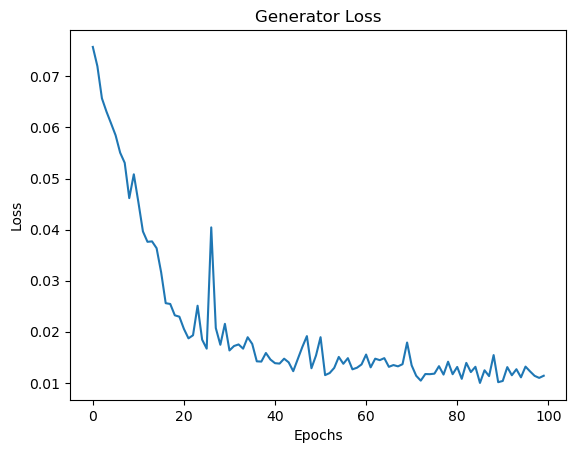

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# Generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)  # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

# Custom Dataset and transformation
class BrainTumorDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_list = os.listdir(data_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_list[idx])
        image = Image.open(image_path).convert("L")  # Convert to grayscale image
        if self.transform:
            image = self.transform(image)
        return image

# Specify the class name for which you want to generate images
class_name = "Meningioma"  # Replace this with the desired class name ("glioma", "meningioma", "notumor", "pituitary")

# Custom Dataset and transformation
data_folder = r'C:\Users\ADMIN\project soft computing\IPDataForMeningioma'
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.Grayscale(),  # Convert to grayscale image
    transforms.ToTensor(),
])
brain_tumor_dataset = BrainTumorDataset(data_folder, transform=transform)

# DataLoader
batch_size = 8  # Reduce the batch size for large images
train_loader = DataLoader(brain_tumor_dataset, batch_size=batch_size, shuffle=True)


# Instantiate the generator with updated input and output size
z_size = 100  # Noise vector size
g_hidden_size = 32
output_size = 1 * 512 * 512  # Update output size for grayscale images
G = Generator(z_size, g_hidden_size, output_size)

# Optimizer
lr = 0.002
g_optimizer = optim.Adam(G.parameters(), lr)

# Training hyperparameters
num_epochs = 100  # Set the number of training epochs
sample_size = 16
fixed_z = torch.randn(sample_size, z_size)


# Training loop
G.train()
losses = []
criterion = nn.MSELoss()  # Use Mean Squared Error (MSE) loss

output_dir = f"generated_images_{class_name}"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for batch_i, real_images in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_size)
        fake_images = G(z)

        # Reshape and resize fake_images to have the same shape as real_images
        fake_images = fake_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]
        real_images = real_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]

        # Calculate generator loss
        g_loss = criterion(fake_images, real_images)

        # Perform backpropagation and optimization step
        g_loss.backward()
        g_optimizer.step()

        # Print the generator loss
        if batch_i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] | Batch [{batch_i + 1}/{len(train_loader)}] | Gen Loss: {g_loss.item():.4f}")

    # Save generator loss for plotting
    losses.append(g_loss.item())

    # Generate and save sample images every few epochs
    if (epoch + 1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            samples_z = G(fixed_z)
        # Rescale generated images back to the range [0, 1]
        samples_z = (samples_z + 1) / 2

        # Save the generated images
        for i, sample in enumerate(samples_z):
            image_path = os.path.join(output_dir, f"generated_image_epoch{epoch + 1}_sample{i + 1}.png")
            # Reshape the tensor to 2D (512x512)
            sample_image = transforms.ToPILImage()(sample.view(512, 512).cpu())
            sample_image.save(image_path)

        G.train()

# Plot the generator loss
plt.plot(losses)
plt.title("Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# for Notumor

Epoch [1/100] | Batch [1/1] | Gen Loss: 0.0699
Epoch [2/100] | Batch [1/1] | Gen Loss: 0.0663
Epoch [3/100] | Batch [1/1] | Gen Loss: 0.0626
Epoch [4/100] | Batch [1/1] | Gen Loss: 0.0593
Epoch [5/100] | Batch [1/1] | Gen Loss: 0.0585
Epoch [6/100] | Batch [1/1] | Gen Loss: 0.0538
Epoch [7/100] | Batch [1/1] | Gen Loss: 0.0519
Epoch [8/100] | Batch [1/1] | Gen Loss: 0.0518
Epoch [9/100] | Batch [1/1] | Gen Loss: 0.0439
Epoch [10/100] | Batch [1/1] | Gen Loss: 0.0458
Epoch [11/100] | Batch [1/1] | Gen Loss: 0.0393
Epoch [12/100] | Batch [1/1] | Gen Loss: 0.0363
Epoch [13/100] | Batch [1/1] | Gen Loss: 0.0414
Epoch [14/100] | Batch [1/1] | Gen Loss: 0.0345
Epoch [15/100] | Batch [1/1] | Gen Loss: 0.0396
Epoch [16/100] | Batch [1/1] | Gen Loss: 0.0309
Epoch [17/100] | Batch [1/1] | Gen Loss: 0.0283
Epoch [18/100] | Batch [1/1] | Gen Loss: 0.0275
Epoch [19/100] | Batch [1/1] | Gen Loss: 0.0257
Epoch [20/100] | Batch [1/1] | Gen Loss: 0.0321
Epoch [21/100] | Batch [1/1] | Gen Loss: 0.0343
E

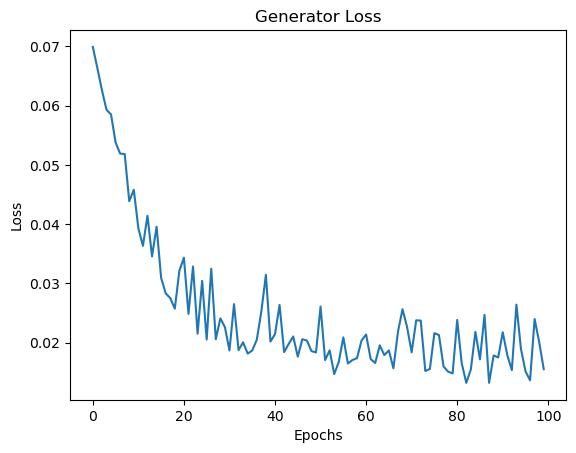

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# Generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)  # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

# Custom Dataset and transformation
class BrainTumorDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_list = os.listdir(data_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_list[idx])
        image = Image.open(image_path).convert("L")  # Convert to grayscale image
        if self.transform:
            image = self.transform(image)
        return image

# Specify the class name for which you want to generate images
class_name = "Notumor"  # Replace this with the desired class name ("glioma", "meningioma", "notumor", "pituitary")

# Custom Dataset and transformation
data_folder = r'C:\Users\ADMIN\project soft computing\IPDataForNotumor'
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.Grayscale(),  # Convert to grayscale image
    transforms.ToTensor(),
])
brain_tumor_dataset = BrainTumorDataset(data_folder, transform=transform)

# DataLoader
batch_size = 8  # Reduce the batch size for large images
train_loader = DataLoader(brain_tumor_dataset, batch_size=batch_size, shuffle=True)


# Instantiate the generator with updated input and output size
z_size = 100  # Noise vector size
g_hidden_size = 32
output_size = 1 * 512 * 512  # Update output size for grayscale images
G = Generator(z_size, g_hidden_size, output_size)

# Optimizer
lr = 0.002
g_optimizer = optim.Adam(G.parameters(), lr)

# Training hyperparameters
num_epochs = 100  # Set the number of training epochs
sample_size = 16
fixed_z = torch.randn(sample_size, z_size)

# ... (Rest of the code remains the same)

# Training loop
G.train()
losses = []
criterion = nn.MSELoss()  # Use Mean Squared Error (MSE) loss

output_dir = f"generated_images_{class_name}"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for batch_i, real_images in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_size)
        fake_images = G(z)

        # Reshape and resize fake_images to have the same shape as real_images
        fake_images = fake_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]
        real_images = real_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]

        # Calculate generator loss
        g_loss = criterion(fake_images, real_images)

        # Perform backpropagation and optimization step
        g_loss.backward()
        g_optimizer.step()

        # Print the generator loss
        if batch_i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] | Batch [{batch_i + 1}/{len(train_loader)}] | Gen Loss: {g_loss.item():.4f}")

    # Save generator loss for plotting
    losses.append(g_loss.item())

    # Generate and save sample images every few epochs
    if (epoch + 1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            samples_z = G(fixed_z)
        # Rescale generated images back to the range [0, 1]
        samples_z = (samples_z + 1) / 2

        # Save the generated images
        for i, sample in enumerate(samples_z):
            image_path = os.path.join(output_dir, f"generated_image_epoch{epoch + 1}_sample{i + 1}.png")
            # Reshape the tensor to 2D (512x512)
            sample_image = transforms.ToPILImage()(sample.view(512, 512).cpu())
            sample_image.save(image_path)

        G.train()

# Plot the generator loss
plt.plot(losses)
plt.title("Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# for Pituitaryt

Epoch [1/100] | Batch [1/1] | Gen Loss: 0.0854
Epoch [2/100] | Batch [1/1] | Gen Loss: 0.0797
Epoch [3/100] | Batch [1/1] | Gen Loss: 0.0746
Epoch [4/100] | Batch [1/1] | Gen Loss: 0.0714
Epoch [5/100] | Batch [1/1] | Gen Loss: 0.0665
Epoch [6/100] | Batch [1/1] | Gen Loss: 0.0599
Epoch [7/100] | Batch [1/1] | Gen Loss: 0.0574
Epoch [8/100] | Batch [1/1] | Gen Loss: 0.0518
Epoch [9/100] | Batch [1/1] | Gen Loss: 0.0449
Epoch [10/100] | Batch [1/1] | Gen Loss: 0.0390
Epoch [11/100] | Batch [1/1] | Gen Loss: 0.0379
Epoch [12/100] | Batch [1/1] | Gen Loss: 0.0305
Epoch [13/100] | Batch [1/1] | Gen Loss: 0.0311
Epoch [14/100] | Batch [1/1] | Gen Loss: 0.0272
Epoch [15/100] | Batch [1/1] | Gen Loss: 0.0234
Epoch [16/100] | Batch [1/1] | Gen Loss: 0.0232
Epoch [17/100] | Batch [1/1] | Gen Loss: 0.0229
Epoch [18/100] | Batch [1/1] | Gen Loss: 0.0209
Epoch [19/100] | Batch [1/1] | Gen Loss: 0.0209
Epoch [20/100] | Batch [1/1] | Gen Loss: 0.0172
Epoch [21/100] | Batch [1/1] | Gen Loss: 0.0203
E

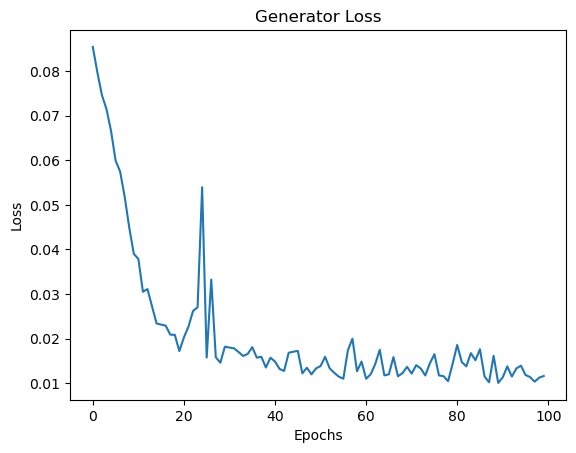

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# Generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)  # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

# Custom Dataset and transformation
class BrainTumorDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_list = os.listdir(data_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_list[idx])
        image = Image.open(image_path).convert("L")  # Convert to grayscale image
        if self.transform:
            image = self.transform(image)
        return image

# Specify the class name for which you want to generate images
class_name = "Pituitaryt"  # Replace this with the desired class name ("glioma", "meningioma", "notumor", "pituitary")

# Custom Dataset and transformation
data_folder = r'C:\Users\ADMIN\project soft computing\IPDataForPituitaryt'
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.Grayscale(),  # Convert to grayscale image
    transforms.ToTensor(),
])
brain_tumor_dataset = BrainTumorDataset(data_folder, transform=transform)

# DataLoader
batch_size = 8  # Reduce the batch size for large images
train_loader = DataLoader(brain_tumor_dataset, batch_size=batch_size, shuffle=True)

# ... (Rest of the code remains the same)

# Instantiate the generator with updated input and output size
z_size = 100  # Noise vector size
g_hidden_size = 32
output_size = 1 * 512 * 512  # Update output size for grayscale images
G = Generator(z_size, g_hidden_size, output_size)

# Optimizer
lr = 0.002
g_optimizer = optim.Adam(G.parameters(), lr)

# ... (Rest of the code remains the same)
# Training hyperparameters
num_epochs = 100  # Set the number of training epochs
sample_size = 16
fixed_z = torch.randn(sample_size, z_size)

# ... (Rest of the code remains the same)

# Training loop
G.train()
losses = []
criterion = nn.MSELoss()  # Use Mean Squared Error (MSE) loss

output_dir = f"generated_images_{class_name}"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for batch_i, real_images in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        # Train the generator
        g_optimizer.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_size)
        fake_images = G(z)

        # Reshape and resize fake_images to have the same shape as real_images
        fake_images = fake_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]
        real_images = real_images.view(batch_size, 1, 512, 512)  # Reshape to [batch_size, 1, 512, 512]

        # Calculate generator loss
        g_loss = criterion(fake_images, real_images)

        # Perform backpropagation and optimization step
        g_loss.backward()
        g_optimizer.step()

        # Print the generator loss
        if batch_i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] | Batch [{batch_i + 1}/{len(train_loader)}] | Gen Loss: {g_loss.item():.4f}")

    # Save generator loss for plotting
    losses.append(g_loss.item())

    # Generate and save sample images every few epochs
    if (epoch + 1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            samples_z = G(fixed_z)
        # Rescale generated images back to the range [0, 1]
        samples_z = (samples_z + 1) / 2

        # Save the generated images
        for i, sample in enumerate(samples_z):
            image_path = os.path.join(output_dir, f"generated_image_epoch{epoch + 1}_sample{i + 1}.png")
            # Reshape the tensor to 2D (512x512)
            sample_image = transforms.ToPILImage()(sample.view(512, 512).cpu())
            sample_image.save(image_path)

        G.train()

# Plot the generator loss
plt.plot(losses)
plt.title("Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
